# 9-6. 프로젝트 : 폐렴 진단기 성능개선

조금 전까지 우리는 대략 80% 정도의 정확도를 가진 X-RAY 사진 판독 폐렴 진단기를 만들어 보았습니다.

하지만 숙련된 의사분들은 90% 이상에 도달한다고 하니, 좀 더 분발해야겠죠?

그렇다면 우리는 조금 전까지의 실습 과정을 되짚어보면서, 어떤 점을 더 개선해볼 수 있을지 따져 보고 스스로 개선해 가면서 더 성능을 향상시켜 보려고 합니다.

# 목차

- step 1. 실험환경 Set-up
- step 2. 데이터 준비하기
- step 3. 데이터 시각화
- step 4. CNN 모델링
     - ResNet 모델링
- step 5. 데이터 불균형처리
- step 6. 모델 훈련
- step 7. 결과 확인과 시각화
    1. precision과 recall의 관계를 확인 -> F1-score (실패)
    2. 시그모이드 함수에서 결정계수를 높여보자 (실패)
    3. PR curve AUC (실패)

<br>

- 회고

    - 이번 프로젝트에서 어려웠던 점
        
        1) ResNet-50의 사용<br>
        2) recall값이 너무 커지는 현상<br>
        3) 평가지표 시각화 실패<br>

    - 프로젝트를 진행하면서 알아낸 점 혹은 아직 모호한 점<br>
        1) L2 규제란?<br>
        2) 항등 매핑<br>
        3) residual block, bottleneck<br>

    - 루브릭 평가 지표를 맞추기 위해 시도한 것들
    - 아쉬운 점

        




# Step 1. 실험환경 Set-up
거의 바꿔볼 수 있을 게 없을 것 같지만, **Batch size**, **Epoch** 등을 변경해볼 수 있을 것입니다.

1.라이브러리 임포트

In [1]:
import os, re
import random, math
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import warnings 
warnings.filterwarnings(action='ignore')

앞으로 필요한 변수들을 생성

In [2]:
# 데이터 로드할 때 빠르게 로드할 수 있도록하는 설정 변수
AUTOTUNE = tf.data.experimental.AUTOTUNE
# X-RAY 이미지 사이즈 변수
IMAGE_SIZE = [180, 180]

# 데이터 경로 변수
ROOT_PATH = '/content/drive/MyDrive/아이펠/풀잎스쿨/data'
TRAIN_PATH = ROOT_PATH + '/chest_xray/data/train/*/*' # *은 모든 디렉토리와 파일을 의미합니다.
VAL_PATH = ROOT_PATH + '/chest_xray/data/val/*/*'
TEST_PATH = ROOT_PATH + '/chest_xray/data/test/*/*'

print(ROOT_PATH)

/content/drive/MyDrive/아이펠/풀잎스쿨/data


In [3]:
# 프로젝트를 진행할 때 아래 두 변수를 변경해보세요
BATCH_SIZE = 16
EPOCHS = 25

# Step 2. 데이터 준비하기
원본 데이터를 가져와서 전처리 및 배치 구성을 진행합니다.
의료 영상 이미지의 특성상 데이터는 언제나 충분하지 않습니다. 이를 극복할 수 있는 방법을 고민해 봅시다.



**1. 데이터 가져오기**

- `train`, `test`, `validation` dataset을 가져온다.

In [4]:
train_filenames = tf.io.gfile.glob(TRAIN_PATH)
test_filenames = tf.io.gfile.glob(TEST_PATH)
val_filenames = tf.io.gfile.glob(VAL_PATH)

print('train :', len(train_filenames), '개')
print('test :', len(test_filenames),'개')
print('validation :', len(val_filenames),'개')

train : 5216 개
test : 624 개
validation : 16 개


- **val 개수**가 너무 없기 때문에 train에서 val에 쓰일 데이터를 더 가져온다.
- train과 val에 있는 데이터를 모은 다음에 **train : val**를 **80:20**으로 분할

In [5]:
# train 데이터와 validation 데이터를 모두 filenames에 담습니다
filenames = tf.io.gfile.glob(TRAIN_PATH)
filenames.extend(tf.io.gfile.glob(VAL_PATH))

# 모아진 filenames를 8:2로 나눕니다
train_size = math.floor(len(filenames)*0.8)
random.seed(8)
random.shuffle(filenames)
train_filenames = filenames[:train_size]
val_filenames = filenames[train_size:]

print(len(train_filenames))
print(len(val_filenames))

4185
1047


- train 데이터 안에 정상 이미지 수와 폐렴 이미지 수 확인

In [6]:
print(f'Normal image path\n{filenames[0]}')
print(f'Pneumonia image path\n{filenames[2000]}')

Normal image path
/content/drive/MyDrive/아이펠/풀잎스쿨/data/chest_xray/data/train/NORMAL/NORMAL2-IM-1090-0001.jpeg
Pneumonia image path
/content/drive/MyDrive/아이펠/풀잎스쿨/data/chest_xray/data/train/PNEUMONIA/person1211_virus_2056.jpeg


In [7]:
# 정상이미지의 수
COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename])
print(f"Normal images count in training set: {COUNT_NORMAL}")

# 폐렴이미지의 수
COUNT_PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename])
print(f"Pneumonia images count in training set: {COUNT_PNEUMONIA}")

Normal images count in training set: 1072
Pneumonia images count in training set: 3113


- 정상이미지수 보다 폐렴이미지수가 3배 더 많음
- CNN 모델의 경우, 클래스별 balance가 좋을수록 training을 잘한다.
- 차후에 train dataset의 불균형을 조정해 준다. (이 떄, test와 validation set은 평가데이터기 때문에 불균형해도 상관없다.)

- tf.data 인스턴스를 만든다. 
- `tf.data`는 tensorflow에서 학습시킬때, mini-batch로 작업할 수 있도록 해 준다.

In [8]:
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

- Train 데이터셋, validation 데이터셋 개수 확인

In [9]:
TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print(f"Training images count: {TRAIN_IMG_COUNT}")

VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print(f"Validating images count: {VAL_IMG_COUNT}")

Training images count: 4185
Validating images count: 1047


- 현재 이미지에는 라벨 데이터가 따로 없다.
- 파일 경로에 **'NORMAL'**이나 **'PNEUMONIA'**가 포함되어 있기 때문에 이를 이용해서 <u>라벨 데이터</u>를 만들어 주는 함수를 만들어 준다.

In [10]:
# 파일 경로의 끝에서 두번째 부분을 확인하면 양성과 음성을 구분할 수 있습니다
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    if parts[-2] == "PNEUMONIA": # 폐렴이면 양성(True), 노말이면 음성(False)
        return 1
    else:
        return 0

- 이미지 데이터는 사이즈가 제각각일 가능성이 높다.
- 이미지의 사이즈를 통일 시키고 GPU 메모리를 더욱 효율적으로 사용하기 위해 이미지 사이즈를 줄인다.

<br>

- `process_path` 함수에서 `decode_img` 함수를 이용해서 이미지의 데이터 타입을 float으로 바꾸고 사이즈를 변경
- `get_label`을 이용해서 라벨 값을 가져온다.

In [11]:
# 이미지를 알맞은 형식으로 바꿉니다.
def decode_img(img):
    img = tf.image.decode_jpeg(img, channels=3) # 이미지를 uint8 tensor로 수정
    img = tf.image.convert_image_dtype(img, tf.float32) # float32 타입으로 수정
    img = tf.image.resize(img, IMAGE_SIZE) # 이미지 사이즈를 IMAGE_SIZE=[180, 180]으로 수정
    return img

# 이미지 파일의 경로를 입력하면 이미지와 라벨을 읽어옵니다.
def process_path(file_path):
    label = get_label(file_path) # 위에서 만든 get_label()을 사용하여 라벨 검출
    img = tf.io.read_file(file_path) # 이미지 읽기
    img = decode_img(img) # 이미지를 알맞은 형식으로 수정
    return img, label

- train 데이터 셋과 validation 데이터 셋 생성
- num_parallel_calls 파라미터에 위에서 할당한 AUTOTUNE변수를 이용하면 더욱 빠르게 데이터를 처리해 즐 수 있다.

In [12]:
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

- 이미지가 잘 리사이즈 되었는지, 라벨이 잘 들어가 있는지 확인

In [13]:
for image, label in train_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (180, 180, 3)
Label:  0


- 맨 처음 지정한 변수 `IMG_SIZE=[180, 180]`, `decode_img()`함수에서 `channel=3`으로 지정한 대로 **사이즈가 잘 변환되었음**
- **라벨 설정 완료** : 폐렴이면 양성(True : 1), 노말이면 음성(False : 0) 👉 지금 출력한 데이터는 `0`이 나왔기 때문에 음성이다.
- `train_ds.take(1)`은 하나의 데이터만 가져온다는 의미이다.

<br>

- train과 validation 데이터셋을 만든 것처럼 test 데이터셋을 만든다.

In [14]:
test_list_ds = tf.data.Dataset.list_files(TEST_PATH)
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

print(TEST_IMAGE_COUNT)

624


- 데이터 개수 확인 : 624개

2. 이전 실습에서 고려하지 않았던 **augmentation**을 사용
- 그러나 <u>의료 영상인 경우,</u> 일반적인 이미지 처리에서 사용하는 augmentation들이 항상 도움이 되진 않는다. 특히 X-RAY 같은 의료 영상의 특성상, 육안으로도 구분하기 어려운 미묘한 차이에 <u>더해진 노이즈 등 부수효과가 오히려 방해를 줄 수도 있기 때문</u>
- 그래서 augmentation 도입은 <u>신중해야 한다.</u>
- 지금은 <u>좌우반전 정도</u>의 **augmentation**을 적용해 본다.

- Tensorflow에서는 `tf.data` <u>파이프라인</u>을 사용해서 학습 데이터를 효율적으로 사용할 수 있도록 해준다.
- `tf.data` 파이프라인을 이용하여 `prepare_for_training()` 함수를 정의해서 데이터를 변환시켜준다.
- `shuffle()`을 사용하며 고정 크기 버퍼를 유지하고 해당 버퍼에서 <u>무작위로 균일하게 다음 요소를 선택</u>
- `repeat()`를 사용하면 epoch를 진행하면서 여러 번 데이터셋을 불러오게 되는데, 이때 repeat()를 사용한 데이터셋의 경우 여러 번 데이터셋을 사용할 수 있다. 
- 100개의 데이터를 10번 반복하면 1000개의 데이터가 필요하게 된다. <u>`repeat()`를 사용하면 자동으로 데이터를 맞춰준다.</u>
- `batch()`를 사용하면 BATCH_SIZE에서 정한 만큼의 배치로 주어진다. 예를 들어, 100개의 데이터를 10개의 배치로 나누게 되면 각 배치에는 10개의 데이터로 나뉜다.
- `prefetch()`를 사용하면 **학습 데이터를 나눠서** 읽어오기 때문에, <u>첫 번째 데이터를 GPU에서 학습하는 동안 두 번째 데이터를 CPU에서 준비할 수 있어 리소스의 유휴 상태를 줄일 수 있다.</u>

In [15]:
def augment(image, label):
    image = tf.image.random_flip_left_right(image)  # 랜덤하게 좌우를 반전합니다.
    return image, label

def prepare_for_training(ds, shuffle_buffer_size=1000):
    # augment 적용 부분이 배치처리 함수에 추가되었습니다.
    ds = ds.map(
            augment,       # 바로 위에서 만든 augment 함수 적용
            num_parallel_calls=2
        )
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE) 
    ds = ds.prefetch(buffer_size=AUTOTUNE)

    return ds

train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

# Step 3. 데이터 시각화
학습용 데이터를 시각화해서 확인해 봅니다.
만약 augmentation을 시도했다면 이후 실습 코드에 있는 show_batch() 함수를 통해 실제로 좌우 반전 등이 제대로 처리되었는지 확인해 봅시다.

- 데이터를 보기 위해 train에 있는 batch 중 첫 번째 배치를 추출
- 추출된 배치를 image와 label 데이터 셋으로 나눈다.

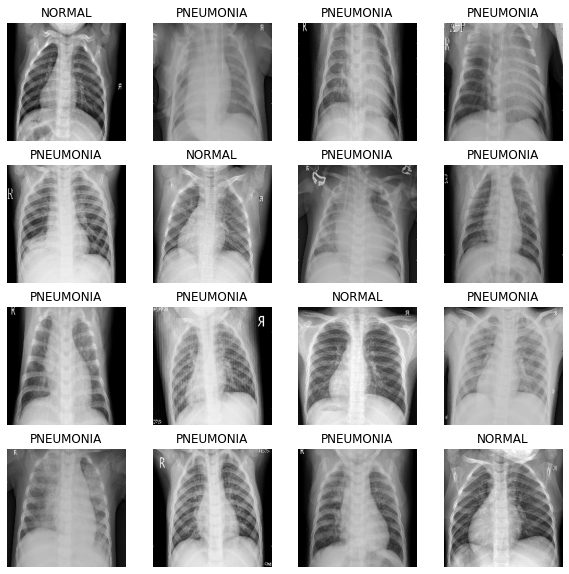

In [16]:
# 이미지 배치를 입력하면 여러장의 이미지를 보여줍니다.
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(BATCH_SIZE):
        ax = plt.subplot(4,math.ceil(BATCH_SIZE/4),n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")


image_batch, label_batch = next(iter(train_ds))
show_batch(image_batch.numpy(), label_batch.numpy())

# Step 4. CNN 모델링
의료 영상 판독을 위해 실습에서 구현했던 model에서 다양한 것들을 바꾸어 가며 실험해볼 수 있습니다. Convolution filter, 채널 개수, activation, 모델 구조 등을 다양하게 바꾸어볼 수 있습니다.

<br>

그리고, 우리는 BatchNormalization과 Dropout을 한 모델 안에서 동시에 사용하는 특이한 구성을 실습했습니다. <br>
(👉 **원래는 Dropout을 사용하면 BatchNormalization을 사용하지 않는다. Dropout이 정규화 방법이기 때문❗**)<br><br> 
이것은 일반적으로 잘 사용되는 형태는 아닙니다. 하지만 이미지 사이즈가 크고 데이터가 부족한 의료 영상에서는 실용적으로 간혹 좋은 성능을 보이기도 합니다. <u>만약 이 구성을 변경해 보면 어떤 효과가 발생하는지도 실험해 봅시다.</u> BatchNormalization을 쓰거나 혹은 쓰지 않거나, Dropout을 쓰거나 혹은 쓰지 않거나 할 수 있습니다. 또, Dropout 비율을 변경해볼 수도 있습니다.

## ResNet 모델링

- 지난 금요일 DEEL ML시간에 나의 발표 파트였던 ***ResNet***을 사용하여 이미지 분류를 시도해 보았다.
- LISVRC'15와 COCO'15 대회에서 우승한 모델 (이미지 분류)
- 152개의 깊은 신경망을 사용함에도 낮은 Error Rate를 기록하며 우승
- **Skip connection**을 사용하는 **Residual Block**을 사용하여 <u>Gradient Vanishing문제를 해결</u>하고 깊은 신경망을 구성할 수 있게 한다.
- <u>***ResNet-50***을 사용하였다.</u>

- 아래 회고에서 📁**L2 규제** 참고

- ResNet은 보통 18, 34, 50, 101, 152의 size를 갖는다.
- 논문에 따르면 ***ResNet-50***이상부터는 *bottleneck block*을 사용하고, 그 미만은 *Normal Block*을 사용한다고 한다. 아래에는 *bottleneck block*만 정의하였다.

<br>

- 아래 회고에서 💾**Residual block, bottleneck** 참고
- 아래 회고에서 📕**항등매핑** 참고

In [17]:
class BottleNeck(tf.keras.layers.Layer):
    def __init__(self, filter_num, stride=1):
        super(BottleNeck, self).__init__()
        self.conv1 = tf.keras.layers.Conv2D(filters=filter_num,
                                            kernel_size=(1, 1),
                                            strides=1,
                                            padding='same')
        self.bn1 = tf.keras.layers.BatchNormalization()
        self.conv2 = tf.keras.layers.Conv2D(filters=filter_num,
                                            kernel_size=(3, 3),
                                            strides=stride,
                                            padding='same')
        self.bn2 = tf.keras.layers.BatchNormalization()
        self.conv3 = tf.keras.layers.Conv2D(filters=filter_num * 4,
                                            kernel_size=(1, 1),
                                            strides=1,
                                            padding='same')
        self.bn3 = tf.keras.layers.BatchNormalization()

        self.downsample = tf.keras.Sequential()
        self.downsample.add(tf.keras.layers.Conv2D(filters=filter_num * 4,
                                                   kernel_size=(1, 1),
                                                   strides=stride))
        self.downsample.add(tf.keras.layers.BatchNormalization())

    def call(self, inputs, training=None, **kwargs):
        residual = self.downsample(inputs)

        x = self.conv1(inputs)
        x = self.bn1(x, training=training)
        x = tf.nn.relu(x)
        x = self.conv2(x)
        x = self.bn2(x, training=training)
        x = tf.nn.relu(x)
        x = self.conv3(x)
        x = self.bn3(x, training=training)

        output = tf.nn.relu(tf.keras.layers.add([residual, x]))

        return output

In [18]:
def make_bottleneck_layer(filter_num, blocks, stride=1):
    res_block = tf.keras.Sequential()
    res_block.add(BottleNeck(filter_num, stride=stride))

    for _ in range(1, blocks):
        res_block.add(BottleNeck(filter_num, stride=1))

    return res_block

In [19]:
class ResNetTypeII(tf.keras.Model):
    def __init__(self, layer_params):
        super(ResNetTypeII, self).__init__()
        self.conv1 = tf.keras.layers.Conv2D(filters=64,
                                            kernel_size=(7, 7),
                                            strides=2,
                                            padding="same")
        self.bn1 = tf.keras.layers.BatchNormalization()
        self.pool1 = tf.keras.layers.MaxPool2D(pool_size=(3, 3),
                                               strides=2,
                                               padding="same")

        self.layer1 = make_bottleneck_layer(filter_num=64,
                                            blocks=layer_params[0])
        self.layer2 = make_bottleneck_layer(filter_num=128,
                                            blocks=layer_params[1],
                                            stride=2)
        self.layer3 = make_bottleneck_layer(filter_num=256,
                                            blocks=layer_params[2],
                                            stride=2)
        self.layer4 = make_bottleneck_layer(filter_num=512,
                                            blocks=layer_params[3],
                                            stride=2)

        self.avgpool = tf.keras.layers.GlobalAveragePooling2D()
        self.fc = tf.keras.layers.Dense(units=1, activation=tf.keras.activations.softmax)

    def call(self, inputs, training=None, mask=None):
        x = self.conv1(inputs)
        x = self.bn1(x, training=training)
        x = tf.nn.relu(x)
        x = self.pool1(x)
        x = self.layer1(x, training=training)
        x = self.layer2(x, training=training)
        x = self.layer3(x, training=training)
        x = self.layer4(x, training=training)
        x = self.avgpool(x)
        output = self.fc(x)

        return output

In [20]:
def resnet_50():
    return ResNetTypeII(layer_params=[3, 4, 6, 3])

In [21]:
model = resnet_50()
model.build([16, 180, 180, 3]) # batchsize = 16
model.summary()

Model: "res_net_type_ii"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             multiple                  9472      
                                                                 
 batch_normalization (BatchN  multiple                 256       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  multiple                 0         
 )                                                               
                                                                 
 sequential (Sequential)     (16, 45, 45, 256)         353664    
                                                                 
 sequential_4 (Sequential)   (16, 23, 23, 512)         2024448   
                                                                 
 sequential_9 (Sequential)   (16, 12, 12, 1024)    

# Step 5. 데이터 imbalance 처리
실습 코드에서 데이터의 imbalance 문제에 대처하기 위해 데이터 비율로 나누어진 **class_weight**를 설정해 주었습니다. <u>만약 이러한 처리를 생략한다면 어떻게 될까요?</u> 또 ***recall을 강조하기 위해*** <u>폐렴 데이터를 잘 맞추는 것을 더 강화하는 효과</u>를 만들어낼 수는 없을까요?

- imbalance한 데이터의 경우 학습 효과가 좋지 않을 수 있으므로 `Weight balancing`을 이용하여 불균형을 처리해준다.
- Weight balancing 은 training set의 각 데이터에서 loss를 계산할 때 특정 클래스의 데이터에 더 큰 loss 값을 갖도록 가중치를 부여하는 방법

<br>

- weight_for_0 : 'Normal' 이미지에 사용할 weight로 셋팅
- weight_for_1 : 'Pneumonia' 이미지에 사용할 weight로 셋팅
- 이 weight들은 'Normal'과 'Pneumonia' 전체 데이터 건수에 반비례하도록 설정된다.

In [22]:
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0 
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0:1, 1:weight_for_1}  # 양성인 1만 사용하기로 한다.

print('Weight for NORMAL: {:.2f}'.format(weight_for_0))
print('Weight for PNEUMONIA: {:.2f}'.format(weight_for_1))

Weight for NORMAL: 1.95
Weight for PNEUMONIA: 0.67


- ~<u>recall값을 더 높이기 위해서,</u> `weight_for_1`만 class_weight로 사용하기로 한다.~
- recall값이 너무 크게 나와서 생략하기로 함.

# Step 6. 모델 훈련
loss 함수를 변경하기는 어렵겠지만, optimizer나 learning rate 등의 변화를 고려해볼 수 있을 것입니다.

- 라벨이 두 개밖에 없기 때문에 "binary_cross entropy" loss를 선택한다
- optimizer로 **SGD**를 사용 <u>(모멘텀 0.9, 학습률 0.01)</u> 👇 *cs231n* ResNet 설명에 따른 optimizer 설정
- 성과지표 metrics으로 **accuracy**, **binary_accuracy**, **precision**, **recall**, **auc**를 사용
- 후에 **F1-score**도 계산하여 사용할 예정

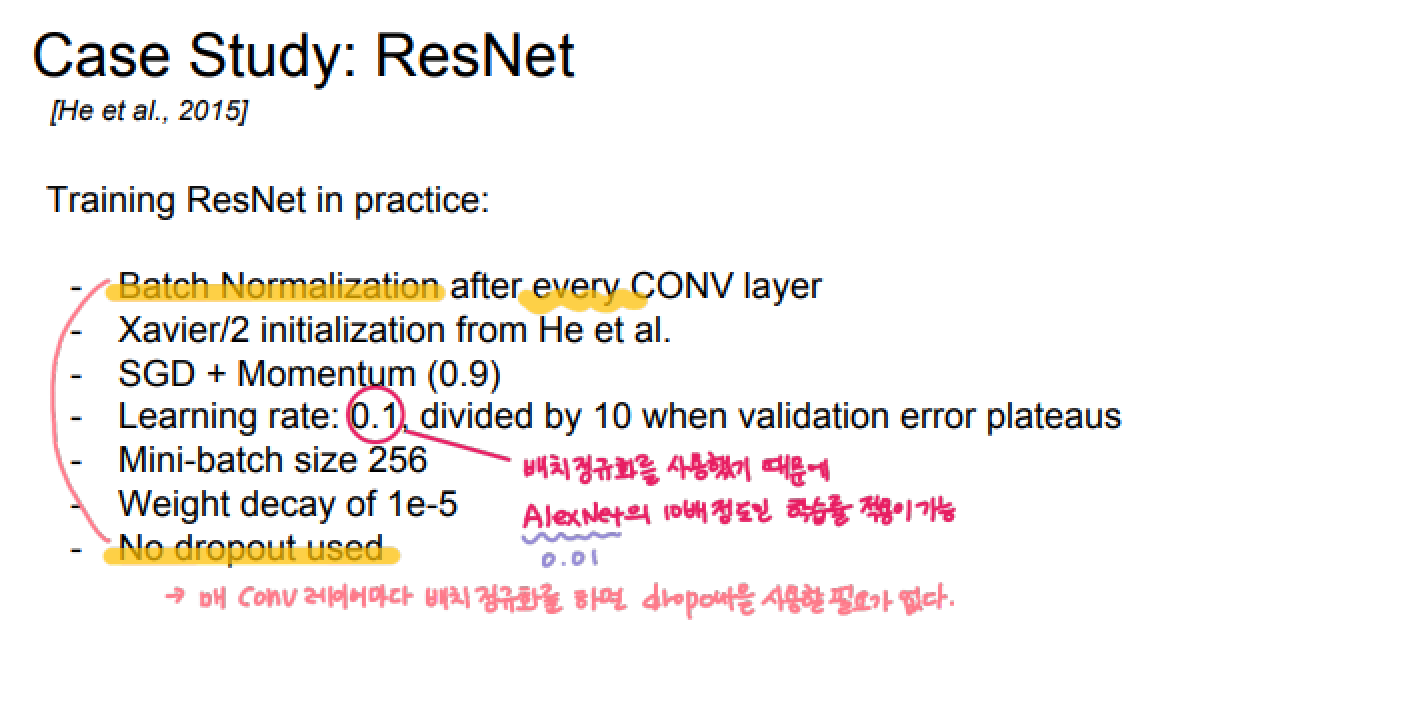

In [30]:
with tf.device('/GPU:0'):

    METRICS = ['accuracy',
               tf.keras.metrics.BinaryAccuracy(name="binary_accuracy", dtype=None, threshold=0.7), 
               tf.keras.metrics.Precision(name='precision'),
               tf.keras.metrics.Recall(name='recall'),
               tf.keras.metrics.AUC(name='auc')]
    
    model.compile(optimizer=tf.keras.optimizers.SGD(
    learning_rate=0.01, momentum=0.9, nesterov=False, name='SGD'),
    loss='binary_crossentropy',metrics=METRICS)

In [ ]:
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE
    ) 

Epoch 1/25
261/261 [==============================] - 291s 1s/step - loss: 0.2987 - accuracy: 0.7435 - binary_accuracy: 0.7435 - precision: 0.7435 - recall: 1.0000 - auc: 0.5000 - val_loss: 0.3979 - val_accuracy: 0.7346 - val_binary_accuracy: 0.7346 - val_precision: 0.7346 - val_recall: 1.0000 - val_auc: 0.5000
Epoch 2/25
261/261 [==============================] - 153s 587ms/step - loss: 0.2333 - accuracy: 0.7438 - binary_accuracy: 0.7438 - precision: 0.7438 - recall: 1.0000 - auc: 0.5000 - val_loss: 0.8825 - val_accuracy: 0.7346 - val_binary_accuracy: 0.7346 - val_precision: 0.7346 - val_recall: 1.0000 - val_auc: 0.5000
Epoch 3/25
261/261 [==============================] - 157s 601ms/step - loss: 0.1827 - accuracy: 0.7443 - binary_accuracy: 0.7443 - precision: 0.7443 - recall: 1.0000 - auc: 0.5000 - val_loss: 0.2324 - val_accuracy: 0.7356 - val_binary_accuracy: 0.7356 - val_precision: 0.7356 - val_recall: 1.0000 - val_auc: 0.5000
Epoch 4/25
261/261 [==============================] - 1

# Step 7. 결과 확인과 시각화
테스트 데이터로 훈련된 모델을 평가해 봅시다. 우선은 accuracy를 고려해야겠지만 의료 영상 모델의 특성상 recall도 중요합니다. 훈련과정의 history 그래프를 시각화해 보고, 학습 진행 양상을 면밀히 분석해 보는 것도 잊지 않도록 합시다.

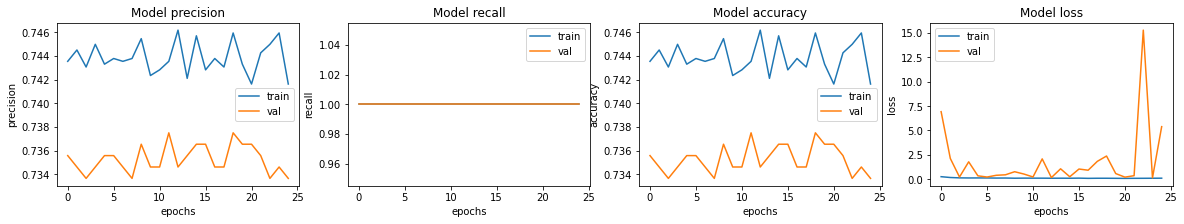

In [25]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss', 'binary_accuracy', 'auc']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

- 테스트 데이터로 모델 평가를 해본다.
- 모델 평가를 위해 loss, accuracy, precision, recall, binary_accuracy, auc값을 출력

In [26]:
loss, accuracy, precision, recall, binary_accuracy, auc = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 [==============================] - 60s 2s/step - loss: 3.9114 - accuracy: 0.6250 - precision: 0.6250 - recall: 1.0000
Loss: 3.9113948345184326,
Accuracy: 0.625,
Precision: 0.625,
Recall: 1.0


## 1.Precision과 Recall의 관계를 확인 👉 F1 Score (지금은 더 못하겠습니다...)

- 의료데이터에서는 양성을 양성으로 판단하는 `recall`지표가 가장 중요하다
- 하지만, `recall`이 너무 높게 나온 경우, 정상도 모두 양성으로 예측한 것은 아닐지 의구심이 든다.
- 서로 반비례 관계인 `precision`과 비교하여 racall과 precision모두 적절한 구간을 찾아볼 수 있으면 좋을 것 같다. -> 이 지표가 `F1 Score`이다.

## 2.시그모이드 함수에서 결정계수를 높여보자 (실패)

- recall이 너무 크게 나와서 여러 방법을 알아보던 차에, 정밀도를 높이고 양성으로 판단하는 기준(결정계수)를 조절하여 무분별한 recall을 줄이고 precision을 높일 수 있다는 것을 알게 되었다.
- 결정계수(threshold)를 0.7로 설정해 본다.
- 0.7이상이면 양성, 이하이면 정상으로 판단된다.

In [34]:
from sklearn.preprocessing import Binarizer

binarizer = Binarizer(threshold = 0.7)
print(binarizer.fit_transform(train_ds))

ValueError: ignored

## 3.PR curve AUC (실패)


- PR curve(Precision Recall curve) '정밀도-재현율 곡선'
- 0부터 1사이의 모든 임계값에 따라 x축을 재현율, y축을 정밀도로 그린 그림
- 정밀도와 재현율 모두 높을수록(그래프의 오른쪽 위) 좋은 모델이라고 할 수 있다.

In [33]:
thresholds= [0.4,0.45,0.5,0.55,0.60,0.65,0.70,0.75]

def get_eval_by_threshold(test_ds, pred_proba_c1, thresholds):
    for custom_threshold in thresholds:
        binarizer = Binarizer(threshold = custom_threshold).fit(pred_proba_c1)
        custom_predict = binarizer.transform(pred_proba_c1)
        print('\n임계값 : ', custom_threshold)
        
        model(test_ds, custom_predict)
        
get_eval_by_threshold(test_ds, pred_proba_1, thresholds)

NameError: ignored

# 회고

## 이번 프로젝트에서 어려웠던 점

### 1) ResNet-50의 사용

- 📗노드 lms 22. 딥네트워크, 서로 뭐가 다른 거죠? 👉 22-10. ResNet-50 의 코드를 참고하였음

<br>

- lms 22의 ResNet-50 코드를 그대로 쓸까 하다가, ResNet-50부터는 ResBlock을 조금 다른것을 쓴다는 논문 발췌를 보고 회고에 자세히 쓰고 싶어서 깃허브에 있는 코드를 사용하기로 함


#### 1-1) 첫번째 시도 : **ResNet 깃허브**에서 코드 사용

- ResNet 깃허브 참고 : https://github.com/calmisential/TensorFlow2.0_ResNet

- 하지만 `model.fit`에서 계속 오류가 났음


```
ValueError: `logits` and `labels` must have the same shape, received ((None, 2) vs (None, 1)).
```
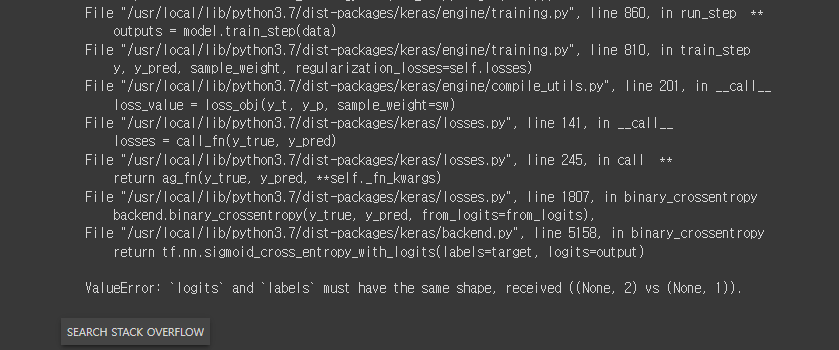![]()

#### 1-2) 두번째 시도 : Keras 내장 API인 ResNet-50 사용

- keras에서 기본으로 ResNet50모델을 지원한다.

In [ ]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers

model = tf.keras.applications.resnet.ResNet50(
    include_top=True, 
    weights=None, 
    input_tensor=None, 
    input_shape=(180,180,3), 
    pooling='avg', classes=1)

- **include_top** : 모델의 최상위 Fully Connected 레이어를 추가할것인지 추가하지 않을것인지 정하는 옵션. ResNet 기본 모델에서는 마지막에 GAP를 사용하고 FC레이어가 하나 있으므로 `True`를 입력해 본다. 
- **weights** : 기존 학습된 가중치 데이터를 읽어들일 가중치 경로. imagenet이라 입력하면 imagenet 데이터셋을 기반으로 기존 학습된 가중치 데이터를 불러온다. 지금은 기존 학습된 데이터가 없으므로 `None`을 지정한다.
- **input_shape** : 3D 텐서 형태를 입력해야한다. 폐렴이미지들은 ***(180, 180, 3)***의 형태로 리사이징 되어있다.
- **classes** : 모델의 마지막 출력 차원을 입력한다. 분류 라벨의 종류라고 생각하면된다. ~폐렴 데이터는 `Nomal`과 `Pneumonia` 두 종류이므로 `2`를 입력한다.~


In [ ]:
model.summary()

- 그래도 똑같은 오류가 떠서 정말... 정말...🙃

#### 1-3) 원인 : ~***batch_size***~ <u>인줄 알았으나 진짜 원인은 따로 있었다</u> ***1-4) 에서 계속***

- label의 shape가 문제라고 자꾸 떠서.. 다시 label을 지정한 부분으로 돌아가서 문제점을 찾음
- `prepare_for_training()`안에서 지정된 `ds = ds.batch(BATCH_SIZE)`때문에 `train_ds`의 요소가 ***(16, 180, 180, 3)***으로 변환되어 있었던 것. 이 때문에 ResNet에서 계속 shape가 맞지 않는다는 에러가 계속 발생했던 것이었다.



#### 1-4) 진짜 원인...
- 진짜 원인은 모델을 구성할 때 마지막 ***FC Layer의 출력 units를 `1`***로 지정해 주어야 했던 것이다. (창수님이 알려줌 ㅂㄷ)
- 아마도 잘하고자 하는 욕심에 밤을 꼴딱 샌 것이... 판단력 저하를 일으킨 것인듯하다.
- 하지만 이젠 다신 헷갈리지 않겠지라는 희망을 가져본다.

<br>

- 결국엔 `classes = 1`을 지정하니 모든 시도가 잘 해결되어서, 첫번째 쓰기로했던 깃허브 코드를 사용하기로 함! 👉 ***BottleNeck***에 대한 설명은 **<u>알아낸 점 3)</u>**에서 계속
- 그리고 모델 빌드가 안되는 문제는 병률퍼실님이 도와주셨다🙏

### 2) recall값이 너무 커지는 현상

- 노드에서 recall값이 중요하기 때문에 recall값을 높이는 방향으로 클래스 가중치를 적용하라고 해서, '정상'인 class 0에는 1(가중치를 주지 않음), '양성'인 class 1에는 계산된 가중치를 주었다.
- 그랬더니 <u>**recall**값은 너무 커져서 계속 1이 나오고, **loss**는 갑자기 한번씩 폭주하는 현상</u>이 일어남
- 그래서 클래스 가중치를 아예 삭제했는데도 같은 현상..
- 원래는 precision을 높이고, recall을 조금 줄이면서 적정한 지점을 찾아보려고 <u>결정계수를 **`0.7`**로 지정</u>해 보았으나, 참고한 블로그들이 모두 머신러닝 관련 내용이라서 코드가 적용되지 않았다.<u>(데이터프레임만 입력가능한 모양이었음. 텐서는 입력되지 않았다.)</u>
- 이론적인 개념만 알고, 코드는 누군가가 실행한 것을 찾아서 써야하는 초보자의 입장으로는 난감한 상황이었다.

### 3) 평가 지표 시각화 실패

- 빅데이터 분석기사 스터디에서 *분류 모형의 평가 지표* 파트에 나온 **ROC**곡선을 시각화 자료로 사용해 보고 싶었으나 쉽지 않았다.
- 아무래도 위의 상황과 같이, 찾은 코드들은 모두 머신러닝에서 데이터 프레임으로 학습하는 코드였던지라 텐서로 reshape한 폐렴 데이터 셋에는 알맞지 않았음
- [텐서플로우 공식문서](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/SGD)에서 `model.compile()`안에서 지정하는 metrics 목록중, ROC 곡선의 지표인 ***AUC*** 옵션이 있길래 보이는대로 일단 metrics에 넣어서 학습을 시켜보았는데, 이렇게 사용하는 것이 맞는지 정확하지 않음

🎁 **ROC 곡선** (Reciever Operating Characteristic Curve: ROC Curve)

-  가로축을 혼동 행렬의 FP로 두고 세로축을 TP로 두어 시각화한 그래프이다.
- ROC 곡선은 그래프가 왼쪽 꼭대기에 가깝게 그려질수록 분류 성능이 우수

<br>

![](https://raw.githubusercontent.com/angeloyeo/angeloyeo.github.io/master/pics/2020-08-05-ROC/pic1.png)

<br>

- FP와 TP는 서로 반비례 관계
- AUC (Area Under ROC)는 진단의 정확도를 측정할 때 사용하는 것으로 ROC 곡선 아래의 면적을 모형의 평가지표로 삼는다.
- AUC의 값은 항상 0.5~1의 값을 가지며 1에 가까울수록 좋은 모형이다.

|AUC|판단기준 설명|
|:------:|:---:|
|0.9 ~ 1.0|Excellent (뛰어남)|
|0.8 ~ 0.9|Good (우수)|
|0.7 ~ 0.8|Fair (보통)|
|0.6 ~ 0.7|Poor (불량)|
|0.5 ~ 0.6|Fail (실패)|

## 프로젝트를 진행하면서 알아낸 점 혹은 아직 모호한 점

### 1) 📁 **L2(Ridge) 규제란**❓ (노드 22에 있는 ResNet-50 코드에는 L2규제를 적용했기 때문에 조사한 내용)

<br>

- **가중치 규제(Weight Regularization)**
    - 가중치 규제는 개별 가중치 값을 제한하여 복잡한 모델을 좀 더 간단하게 하는 방법 
    - 복잡한 모델은 많은 수의 매개변수를 가진 모델로, <u>과적합이 일어날 가능성</u>이 크므로 가중치를 규제해 준다.

<br>

- L2 규제는 모든 가중치 $w$의 제곱합을 비용 함수(cost function)에 추가한다.
- 기존의 비용 함수에 모든 가중치에 대해서 $\lambda\frac{1}{2}|w|^{2}$를 더한 값을 비용 함수로 한다.

- $cost(W, b)=\frac{1}{m}\sum_{i}^{m}L(\hat{y_{i}}, y_{i})+\lambda\frac{1}{2}|w|^{2}$

- $\lambda$는 **규제의 강도**를 정하는 하이퍼 파라미터이다. <u>0에 가까울수록 정규화의 효과는 사라진다.</u>
- 비용 함수를 최소화하기 위해서는 가중치 $w$들의 값이 작아져야한다.

### 3) 📕 **항등 매핑(identity mapping)이란?**

- 낮은 계층에 얕은 모델을 복사 그 위에 항등 매핑 계층을 쌓는다.
- 학습이 필요하면 입/출력 매핑을 학습하고, 학습이 필요 없으면 입력을 그대로 통과하도록 만든다.
- 학습 여부에 따라 두 개의 경로를 만들어서 한쪽 경로는 학습하는 경로 다른 쪽은 항등 매핑 경로로 삼는다.

image.png

### 3) 💾**residual block, bottleneck**

- ResNet-18,34는 왼쪽 residual block을 사용하고, ResNet-50 부터는 오른쪽 BottleNeck을 사용

![](https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fblog.kakaocdn.net%2Fdn%2Fcjoceg%2Fbtq0ulXxaaM%2FdkAS3aQHHg6BU4ReLgxsFk%2Fimg.png)

- 기본 residual block은 `3x3` 필터를 사용하는 **conv2D**를 두 번 사용한 뒤, `relu`이전에 output과 입력을 더해준다.
- BottleNeck은 `1x1` → `3x3` → `1x1` 필터를 사용하는 **conv2D**를 3번 사용한 뒤 output과 입력을 더해주는 방식을 사용한다.

## 루브릭 평가 지표를 맞추기 위해 시도한 것들

|평가문항|상세기준|
|:------|:---|
|1. 의료영상을 처리하는 CNN 기반 딥러닝 모델이 잘 구현되었다|모델 학습이 안정적으로 수렴하는 것을 시각화를 통해 확인하였다.|
|2. 데이터 준비, 모델구성 등의 과정의 다양한 실험이 체계적으로 수행되었다.|regularization, augmentation 등의 기법의 사용 여부에 따른 모델 성능 측정이 ablation study 형태로 체계적으로 수행되었다.|
|3. 실습코드를 잘 개선하여 폐렴 검출 정확도가 추가로 향상되었다.|Accuracy 기준 85%에 도달하였다.|

- ResNet이 이미지 분류 성능이 좋다고 해서 써봤음 (실패)
- recall값을 잡아보려했지만 어디서 손대야할지 몰라서 못함 (실패)
- ROC 곡선도 이론만 알지말고 써보자! 마침 분류 모델이니까! 라고 생각해서 시도했지만 쓸줄도 모르고 어찌해야할지 모른채로 장렬히 실패
- 생각해보니.. 원래코드에서는 optimizer가 'adam'으로 되어있었는데, 하도 성능이 구려서 원래 ResNet에서 사용했다던 `SGD`와 `모멘텀=0.9`, `학습률=0.01`를 적용해봤지만 딱히 더 좋아진 것은 없었다.

## 아쉬운점

    

- 여러가지 모델을 적용시켜보지 못한것이 아쉽다. <br>
배운내용을 프로젝트에 사용해 보는 시도는 좋았으나, 아무래도 경험이 없다보니 간단한 방법이 있었는데도 잘 몰라서 많은 시간을 헤맸더니 너무 힘들었고... 막상 제출하려니 더 잘해볼 수 있었을텐데 미루다가 늦게 시작한 것이 또 아쉬웠다.
- 이미 하던 것이고, 고민한게 아까워서 버리지 못해서 계속 ResNet을 썼지만 처참하게 실패하니 자신감이 떨어졌다.
- 이론과 실제 코딩의 괴리감을 격하게 느낀 익스였다. 과욕이 부른 대참사 ~(하라는 대로 할 것을...)~

